In [ ]:
!git clone http://github.com/jingw2/demand_forecast

Cloning into 'demand_forecast'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 254 (delta 27), reused 5 (delta 1), pack-reused 194
Receiving objects: 100% (254/254), 1.06 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (118/118), done.


Cloning into 'TimeSeries'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 110 (delta 0), reused 1 (delta 0), pack-reused 107
Receiving objects: 100% (110/110), 1.31 MiB | 27.44 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
%cd demand_forecast
import torch 
from torch import nn
import torch.nn.functional as F 
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
import util
from datetime import date
import argparse
from progressbar import *

/content/demand_forecast


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data/naphtha/prep/WTI.csv")#, index = False)
data.to_csv("/content/demand_forecast/data/WTI.csv", index = False)
data.head()

,Price_wti,Vol_wti,date,Price_us2bond,Price_us10bond,Price_us30,Vol_us30,Price_snp
0,106.17,175.47,2014-06-23,0.468,2.626,16840.0,95.63,1962.61
1,106.03,175.21,2014-06-24,0.460,2.577,16752.0,142.75,1949.98
2,106.50,249.06,2014-06-25,0.484,2.561,16771.0,129.82,1959.53
3,105.84,195.72,2014-06-26,0.469,2.532,16762.0,150.59,1957.22
4,105.74,128.98,2014-06-27,0.465,2.536,16757.0,109.97,1960.96


In [ ]:

class Gaussian(nn.Module):

    def __init__(self, hidden_size, output_size):
        '''
        Gaussian Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Gaussian, self).__init__()
        self.mu_layer = nn.Linear(hidden_size, output_size)
        self.sigma_layer = nn.Linear(hidden_size, output_size)

        # initialize weights
        # nn.init.xavier_uniform_(self.mu_layer.weight)
        # nn.init.xavier_uniform_(self.sigma_layer.weight)
    
    def forward(self, h):
        _, hidden_size = h.size()
        sigma_t = torch.log(1 + torch.exp(self.sigma_layer(h))) + 1e-6
        sigma_t = sigma_t.squeeze(0)
        mu_t = self.mu_layer(h).squeeze(0)
        return mu_t, sigma_t

class NegativeBinomial(nn.Module):

    def __init__(self, input_size, output_size):
        '''
        Negative Binomial Supports Positive Count Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(NegativeBinomial, self).__init__()
        self.mu_layer = nn.Linear(input_size, output_size)
        self.sigma_layer = nn.Linear(input_size, output_size)
    
    def forward(self, h):
        _, hidden_size = h.size()
        alpha_t = torch.log(1 + torch.exp(self.sigma_layer(h))) + 1e-6
        mu_t = torch.log(1 + torch.exp(self.mu_layer(h)))
        return mu_t, alpha_t

def gaussian_sample(mu, sigma):
    '''
    Gaussian Sample
    Args:
    ytrue (array like)
    mu (array like)
    sigma (array like): standard deviation
    gaussian maximum likelihood using log 
        l_{G} (z|mu, sigma) = (2 * pi * sigma^2)^(-0.5) * exp(- (z - mu)^2 / (2 * sigma^2))
    '''
    # likelihood = (2 * np.pi * sigma ** 2) ** (-0.5) * \
    #         torch.exp((- (ytrue - mu) ** 2) / (2 * sigma ** 2))
    # return likelihood
    gaussian = torch.distributions.normal.Normal(mu, sigma)
    ypred = gaussian.sample(mu.size())
    return ypred

def negative_binomial_sample(mu, alpha):
    '''
    Negative Binomial Sample
    Args:
    ytrue (array like)
    mu (array like)
    alpha (array like)
    maximuze log l_{nb} = log Gamma(z + 1/alpha) - log Gamma(z + 1) - log Gamma(1 / alpha)
                - 1 / alpha * log (1 + alpha * mu) + z * log (alpha * mu / (1 + alpha * mu))
    minimize loss = - log l_{nb}
    Note: torch.lgamma: log Gamma function
    '''
    var = mu + mu * mu * alpha
    ypred = mu + torch.randn(mu.size()) * torch.sqrt(var)
    return ypred

class DeepAR(nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, num_layers, lr=1e-3, likelihood="g"):
        super(DeepAR, self).__init__()

        # network
        self.input_embed = nn.Linear(1, embedding_size)
        self.encoder = nn.LSTM(embedding_size+input_size, hidden_size, \
                num_layers, bias=True, batch_first=True)
        if likelihood == "g":
            self.likelihood_layer = Gaussian(hidden_size, 1)
        elif likelihood == "nb":
            self.likelihood_layer = NegativeBinomial(hidden_size, 1)
        self.likelihood = likelihood
    
    def forward(self, X, y, Xf):
        '''
        Args:
        X (array like): shape (num_time_series, seq_len, input_size)
        y (array like): shape (num_time_series, seq_len)
        Xf (array like): shape (num_time_series, horizon, input_size)
        Return:
        mu (array like): shape (batch_size, seq_len)
        sigma (array like): shape (batch_size, seq_len)
        '''
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            Xf = torch.from_numpy(Xf).float()
        num_ts, seq_len, _ = X.size()
        _, output_horizon, num_features = Xf.size()
        ynext = None
        ypred = []
        mus = []
        sigmas = []
        h, c = None, None
        for s in range(seq_len + output_horizon):
            if s < seq_len:
                ynext = y[:, s].view(-1, 1)
                yembed = self.input_embed(ynext).view(num_ts, -1)
                x = X[:, s, :].view(num_ts, -1)
            else:
                yembed = self.input_embed(ynext).view(num_ts, -1)
                x = Xf[:, s-seq_len, :].view(num_ts, -1)
            x = torch.cat([x, yembed], dim=1) # num_ts, num_features + embedding
            inp = x.unsqueeze(1)
            if h is None and c is None:
                out, (h, c) = self.encoder(inp) # h size (num_layers, num_ts, hidden_size)
            else:
                out, (h, c) = self.encoder(inp, (h, c))
            hs = h[-1, :, :]
            hs = F.relu(hs)
            mu, sigma = self.likelihood_layer(hs)
            mus.append(mu.view(-1, 1))
            sigmas.append(sigma.view(-1, 1))
            if self.likelihood == "g":
                ynext = gaussian_sample(mu, sigma)
            elif self.likelihood == "nb":
                alpha_t = sigma
                mu_t = mu
                ynext = negative_binomial_sample(mu_t, alpha_t)
            # if without true value, use prediction
            if s >= seq_len - 1 and s < output_horizon + seq_len - 1:
                ypred.append(ynext)
        ypred = torch.cat(ypred, dim=1).view(num_ts, -1)
        mu = torch.cat(mus, dim=1).view(num_ts, -1)
        sigma = torch.cat(sigmas, dim=1).view(num_ts, -1)
        return ypred, mu, sigma
    
def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int):
    seq_len (int): sequence/encoder/decoder length
    batch_size (int)
    '''
    num_ts, num_periods, _ = X.shape
    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    batch = random.sample(range(num_ts), batch_size)
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len]
    yf = y[batch, t:t+seq_len]
    return X_train_batch, y_train_batch, Xf, yf

def train(
    X, y, args
    ):
    '''
    Args:
    - X (array like): shape (num_samples, num_features, num_periods)
    - y (array like): shape (num_samples, num_periods)
    - epoches (int): number of epoches to run
    - step_per_epoch (int): steps per epoch to run
    - seq_len (int): output horizon
    - likelihood (str): what type of likelihood to use, default is gaussian
    - num_skus_to_show (int): how many skus to show in test phase
    - num_results_to_sample (int): how many samples in test phase as prediction
    '''
    num_ts, num_periods, num_features = X.shape
    model = DeepAR(num_features, args.embedding_size, 
        args.hidden_size, args.n_layers, args.lr, args.likelihood)
    optimizer = Adam(model.parameters(), lr=args.lr)
    random.seed(2)
    # select sku with most top n quantities 
    Xtr, ytr, Xte, yte = util.train_test_split(X, y)
    losses = []
    cnt = 0

    yscaler = None
    if args.standard_scaler:
        yscaler = util.StandardScaler()
    elif args.log_scaler:
        yscaler = util.LogScaler()
    elif args.mean_scaler:
        yscaler = util.MeanScaler()
    if yscaler is not None:
        ytr = yscaler.fit_transform(ytr)

    # training
    seq_len = args.seq_len
    num_obs_to_train = args.num_obs_to_train
    progress = ProgressBar()
    for epoch in progress(range(args.num_epoches)):
        # print("Epoch {} starts...".format(epoch))
        for step in range(args.step_per_epoch):
            Xtrain, ytrain, Xf, yf = batch_generator(Xtr, ytr, num_obs_to_train, seq_len, args.batch_size)
            Xtrain_tensor = torch.from_numpy(Xtrain).float()
            ytrain_tensor = torch.from_numpy(ytrain).float()
            Xf = torch.from_numpy(Xf).float()  
            yf = torch.from_numpy(yf).float()
            ypred, mu, sigma = model(Xtrain_tensor, ytrain_tensor, Xf)
            # ypred_rho = ypred
            # e = ypred_rho - yf
            # loss = torch.max(rho * e, (rho - 1) * e).mean()
            ## gaussian loss
            ytrain_tensor = torch.cat([ytrain_tensor, yf], dim=1)
            if args.likelihood == "g":
                loss = util.gaussian_likelihood_loss(ytrain_tensor, mu, sigma)
            elif args.likelihood == "nb":
                loss = util.negative_binomial_loss(ytrain_tensor, mu, sigma)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cnt += 1
    
    # test 
    mape_list = []
    # select skus with most top K
    X_test = Xte[:, -seq_len-num_obs_to_train:-seq_len, :].reshape((num_ts, -1, num_features))
    Xf_test = Xte[:, -seq_len:, :].reshape((num_ts, -1, num_features))
    y_test = yte[:, -seq_len-num_obs_to_train:-seq_len].reshape((num_ts, -1))
    yf_test = yte[:, -seq_len:].reshape((num_ts, -1))
    if yscaler is not None:
        y_test = yscaler.transform(y_test)
    result = []
    n_samples = args.sample_size
    for _ in tqdm(range(n_samples)):
        y_pred, _, _ = model(X_test, y_test, Xf_test)
        y_pred = y_pred.data.numpy()
        if yscaler is not None:
            y_pred = yscaler.inverse_transform(y_pred)
        result.append(y_pred.reshape((-1, 1)))
    
    result = np.concatenate(result, axis=1)
    p50 = np.quantile(result, 0.5, axis=1)
    p90 = np.quantile(result, 0.9, axis=1)
    p10 = np.quantile(result, 0.1, axis=1)
    
    mape = util.MAPE(yf_test, p50)
    print("P50 MAPE: {}".format(mape))
    mape_list.append(mape)

    if args.show_plot:
        plt.figure(1, figsize=(20, 5))
        plt.plot([k + seq_len + num_obs_to_train - seq_len \
            for k in range(seq_len)], p50, "r-")
        plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
            y1=p10, y2=p90, alpha=0.5)
        plt.title('Prediction uncertainty')
        yplot = yte[-1, -seq_len-num_obs_to_train:]
        plt.plot(range(len(yplot)), yplot, "k-")
        plt.legend(["P50 forecast", "true", "P10-P90 quantile"], loc="upper left")
        ymin, ymax = plt.ylim()
        plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        plt.ylim(ymin, ymax)
        plt.xlabel("Periods")
        plt.ylabel("Y")
        plt.show()
    return losses, mape_list


In [ ]:

import easydict
 
args = easydict.EasyDict({
		"num_epoches":100,
		"step_per_epoch" : 4,
		"lr" : 1e-4,
		"n_layers" : 5,
		"hidden_size" : 50,
		"embedding_size" : 10,
		"likelihood":"g",
		"seq_len" : 40,
		"num_obs_to_train" : 200,
		"num_results_to_sample" : 10,
		"show_plot" : "store_true",
		"run_test" : "store_true",
		"standard_scaler" : "store_true",
		"log_scaler" : "store_true",
		"mean_scaler" : "store_true",
		"batch_size" : 64,
		"sample_size" : 100,
})
args

{'batch_size': 64,
 'embedding_size': 10,
 'hidden_size': 50,
 'likelihood': 'g',
 'log_scaler': 'store_true',
 'lr': 0.0001,
 'mean_scaler': 'store_true',
 'n_layers': 5,
 'num_epoches': 100,
 'num_obs_to_train': 200,
 'num_results_to_sample': 10,
 'run_test': 'store_true',
 'sample_size': 100,
 'seq_len': 40,
 'show_plot': 'store_true',
 'standard_scaler': 'store_true',
 'step_per_epoch': 4}

100% (100 of 100) |######################| Elapsed Time: 0:03:41 Time:  0:03:41
100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


P50 MAPE: 0.2653220700523769


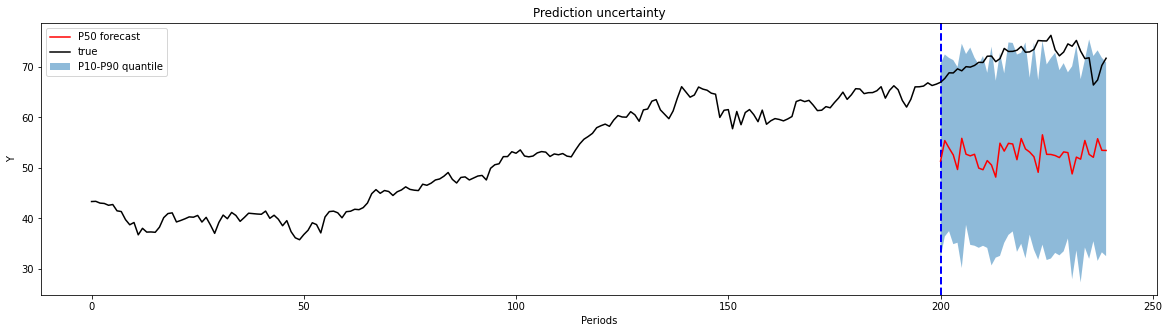

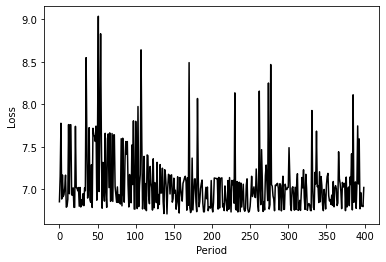

In [ ]:

if args.run_test:
    data_path = util.get_data_path()
    data = pd.read_csv(os.path.join(data_path, "WTI.csv"), parse_dates=["date"])
    data["year"] = data["date"].apply(lambda x: x.year)
    data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
    data["month"] = data["date"].apply(lambda x: x.month)
    data["day"] = data["date"].apply(lambda x: x.day)
    # data = data.loc[(data["date"] >= pd.Timestamp(2014, 1, 1)) & (data["date"] <= pd.Timestamp(2014, 3, 1))]

    features = ["year","month","day", "day_of_week"]
    # hours = pd.get_dummies(data["hour"])
    # dows = pd.get_dummies(data["day_of_week"])
    # hours = data["day"]
    # dows1 = data["year"] 
    # dows2 = data["month"] 
    # dows3 = data[ "day"] 
    # dows4 = data[ "day_of_week"] 
    dows5 = data["Vol_wti"] 

    dows6 = data[ "Price_snp"] 
    dows7 = data[ "Price_us2bond"] 
    dows8 = data[ "Price_us10bond"] 
    dows9 = data["Price_us30"]
    X = np.c_[ #np.asarray(dows1),
                # np.asarray(dows2),
                # np.asarray(dows3),
                # np.asarray(dows4),
                np.asarray(dows5),
                np.asarray(dows6),
                np.asarray(dows7),
                np.asarray(dows8),
                np.asarray(dows9)]

    num_features = X.shape[1]
    num_periods = len(data)
    X = np.asarray(X).reshape((-1, num_periods, num_features))
    y = np.asarray(data["Price_wti"]).reshape((-1, num_periods))
    # X = np.tile(X, (10, 1, 1))
    # y = np.tile(y, (10, 1))
    losses, mape_list = train(X, y, args)
    if args.show_plot:
        plt.plot(range(len(losses)), losses, "k-")
        plt.xlabel("Period")
        plt.ylabel("Loss")
        plt.show()


In [ ]:
data[-240:]

,Price_wti,Vol_wti,date,Price_us2bond,Price_us10bond,Price_us30,Vol_us30,Price_snp,year,day_of_week,month,day
1528,23.63,797.71,2020-04-07,0.2680,0.726,22491.0,275.76,2659.41,2020,1,4,7
1529,25.09,823.55,2020-04-08,0.2560,0.771,23246.0,238.33,2749.98,2020,2,4,8
1530,22.76,1.12,2020-04-09,0.2314,0.729,23618.0,262.87,2789.82,2020,3,4,9
1531,22.41,775.12,2020-04-13,0.2492,0.770,23309.0,159.04,2761.63,2020,0,4,13
1532,20.11,785.48,2020-04-14,0.2210,0.750,23880.0,174.57,2846.06,2020,1,4,14
...,...,...,...,...,...,...,...,...,...,...,...,...
1763,60.64,456.68,2021-03-01,0.1211,1.426,31509.0,207.99,3901.82,2021,0,3,1
1764,59.75,464.13,2021-03-02,0.1230,1.398,31358.0,207.25,3870.29,2021,1,3,2
1765,61.28,465.31,2021-03-03,0.1427,1.484,31236.0,255.15,3819.72,2021,2,3,3
1766,63.83,694.63,2021-03-04,0.1467,1.557,30878.0,410.09,3768.47,2021,3,3,4


100% (100 of 100) |######################| Elapsed Time: 0:03:42 Time:  0:03:42
100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


P50 MAPE: 0.1612417840321473


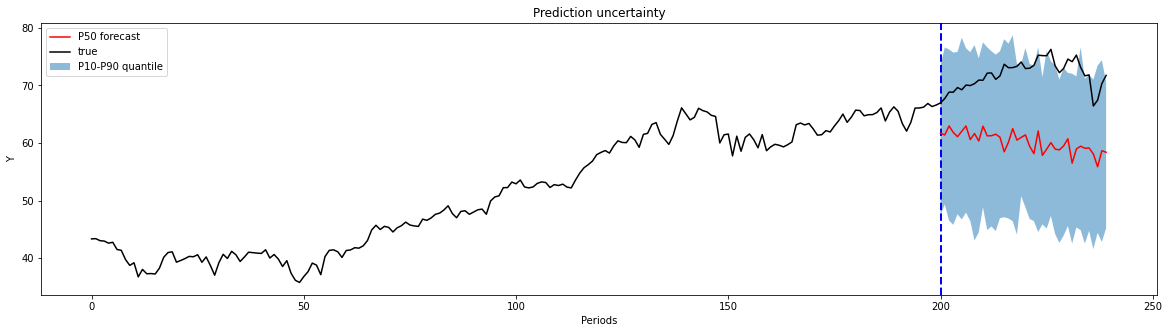

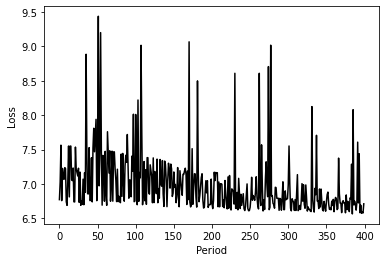

In [ ]:

if args.run_test:
    data_path = util.get_data_path()
    data = pd.read_csv(os.path.join(data_path, "WTI.csv"), parse_dates=["date"])
    data["year"] = data["date"].apply(lambda x: x.year)
    data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
    data["month"] = data["date"].apply(lambda x: x.month)
    data["day"] = data["date"].apply(lambda x: x.day)
    # data = data.loc[(data["date"] >= pd.Timestamp(2014, 1, 1)) & (data["date"] <= pd.Timestamp(2014, 3, 1))]

    features = ["year","month","day", "day_of_week"]
    # hours = pd.get_dummies(data["hour"])
    # dows = pd.get_dummies(data["day_of_week"])
    # hours = data["day"]
    # dows1 = data["year"] 
    dows2 = data["month"] 
    # dows3 = data[ "day"] 
    # dows4 = data[ "day_of_week"] 
    dows5 = data["Vol_wti"] 

    dows6 = data[ "Price_snp"] 
    dows7 = data[ "Price_us2bond"] 
    dows8 = data[ "Price_us10bond"] 
    dows9 = data["Price_us30"]
    X = np.c_[ #np.asarray(dows1),
                np.asarray(dows2)]
                # np.asarray(dows3),
                # np.asarray(dows4),
                # np.asarray(dows5),
                # np.asarray(dows6),
                # np.asarray(dows7),
                # np.asarray(dows8),
                # np.asarray(dows9)]

    num_features = X.shape[1]
    num_periods = len(data)
    X = np.asarray(X).reshape((-1, num_periods, num_features))
    y = np.asarray(data["Price_wti"]).reshape((-1, num_periods))
    # X = np.tile(X, (10, 1, 1))
    # y = np.tile(y, (10, 1))
    losses, mape_list = train(X, y, args)
    if args.show_plot:
        plt.plot(range(len(losses)), losses, "k-")
        plt.xlabel("Period")
        plt.ylabel("Loss")
        plt.show()


100% (500 of 500) |######################| Elapsed Time: 0:19:11 Time:  0:19:11
100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


P50 MAPE: 0.10040526228181519


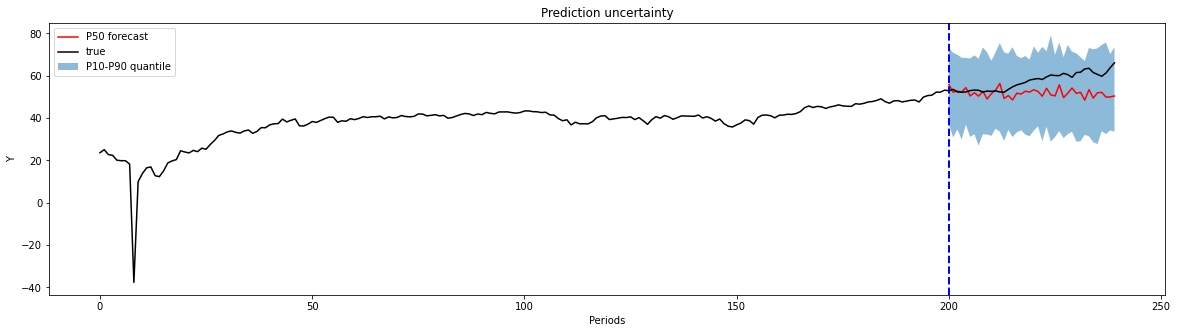

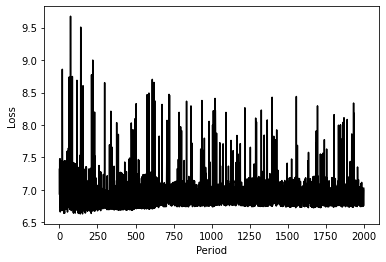

In [ ]:

import easydict
 
args = easydict.EasyDict({
		"num_epoches":500,
		"step_per_epoch" : 4,
		"lr" : 1e-4,
		"n_layers" : 5,
		"hidden_size" : 50,
		"embedding_size" : 10,
		"likelihood":"g",
		"seq_len" : 40,
		"num_obs_to_train" : 200,
		"num_results_to_sample" : 10,
		"show_plot" : "store_true",
		"run_test" : "store_true",
		"standard_scaler" : "store_true",
		"log_scaler" : "store_true",
		"mean_scaler" : "store_true",
		"batch_size" : 64,
		"sample_size" : 100,
})
args
if args.run_test:
    data_path = util.get_data_path()
    data = pd.read_csv(os.path.join(data_path, "WTI.csv"), parse_dates=["date"])[:-100]
    data["year"] = data["date"].apply(lambda x: x.year)
    data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
    data["month"] = data["date"].apply(lambda x: x.month)
    data["day"] = data["date"].apply(lambda x: x.day)
    # data = data.loc[(data["date"] >= pd.Timestamp(2014, 1, 1)) & (data["date"] <= pd.Timestamp(2014, 3, 1))]

    features = ["year","month","day", "day_of_week"]
    # hours = pd.get_dummies(data["hour"])
    # dows = pd.get_dummies(data["day_of_week"])
    # hours = data["day"]
    dows1 = data["year"] 
    dows2 = data["month"] 
    dows3 = data[ "day"] 
    dows4 = data[ "day_of_week"] 
    dows5 = data["Vol_wti"] 

    dows6 = data[ "Price_snp"] 
    dows7 = data[ "Price_us2bond"] 
    dows8 = data[ "Price_us10bond"] 
    dows9 = data["Price_us30"]
    X = np.c_[ np.asarray(dows1),
                np.asarray(dows2),
                np.asarray(dows3),
                np.asarray(dows4)]
                # np.asarray(dows5),
                # np.asarray(dows6),
                # np.asarray(dows7),
                # np.asarray(dows8),
                # np.asarray(dows9)]

    num_features = X.shape[1]
    num_periods = len(data)
    X = np.asarray(X).reshape((-1, num_periods, num_features))
    y = np.asarray(data["Price_wti"]).reshape((-1, num_periods))
    # X = np.tile(X, (10, 1, 1))
    # y = np.tile(y, (10, 1))
    losses, mape_list = train(X, y, args)
    if args.show_plot:
        plt.plot(range(len(losses)), losses, "k-")
        plt.xlabel("Period")
        plt.ylabel("Loss")
        plt.show()


100% (1000 of 1000) |####################| Elapsed Time: 0:34:56 Time:  0:34:56
100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


P50 MAPE: 0.27026821084581415


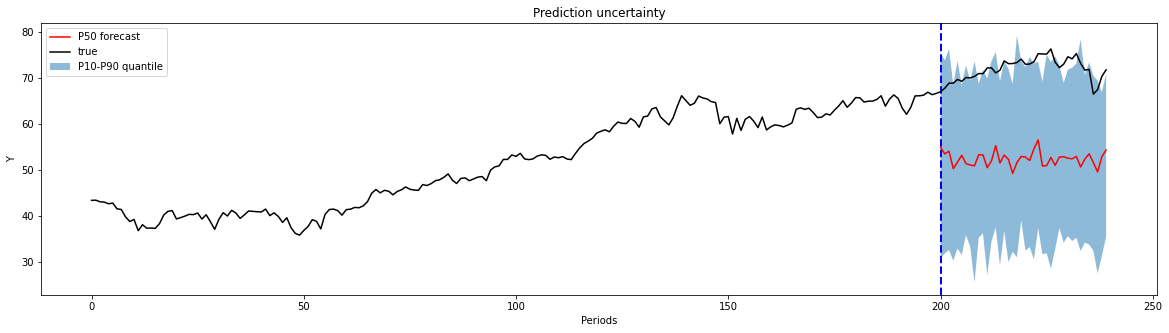

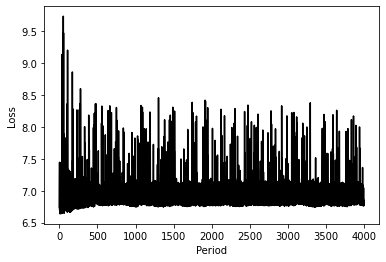

In [ ]:

if args.run_test:
    data_path = util.get_data_path()
    data = pd.read_csv(os.path.join(data_path, "WTI.csv"), parse_dates=["date"])
    data["year"] = data["date"].apply(lambda x: x.year)
    data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
    data["month"] = data["date"].apply(lambda x: x.month)
    data["day"] = data["date"].apply(lambda x: x.day)
    # data = data.loc[(data["date"] >= pd.Timestamp(2014, 1, 1)) & (data["date"] <= pd.Timestamp(2014, 3, 1))]

    features = ["year","month","day", "day_of_week"]
    # hours = pd.get_dummies(data["hour"])
    # dows = pd.get_dummies(data["day_of_week"])
    # hours = data["day"]
    dows1 = data["year"] 
    dows2 = data["month"] 
    dows3 = data[ "day"] 
    dows4 = data[ "day_of_week"] 
    dows5 = data["Vol_wti"] 

    dows6 = data[ "Price_snp"] 
    dows7 = data[ "Price_us2bond"] 
    dows8 = data[ "Price_us10bond"] 
    dows9 = data["Price_us30"]
    X = np.c_[ np.asarray(dows1),
                np.asarray(dows2),
                np.asarray(dows3),
                # np.asarray(dows4),
                np.asarray(dows5),
                np.asarray(dows6),
                np.asarray(dows7),
                np.asarray(dows8),
                np.asarray(dows9)]

    num_features = X.shape[1]
    num_periods = len(data)
    X = np.asarray(X).reshape((-1, num_periods, num_features))
    y = np.asarray(data["Price_wti"]).reshape((-1, num_periods))
    # X = np.tile(X, (10, 1, 1))
    # y = np.tile(y, (10, 1))
    losses, mape_list = train(X, y, args)
    if args.show_plot:
        plt.plot(range(len(losses)), losses, "k-")
        plt.xlabel("Period")
        plt.ylabel("Loss")
        plt.show()


In [ ]:
data

,Price_wti,Vol_wti,date,Price_us2bond,Price_us10bond,Price_us30,Vol_us30,Price_snp,year,day_of_week,month,day
0,106.17,175.47,2014-06-23,0.4680,2.626,16840.0,95.63,1962.61,2014,0,6,23
1,106.03,175.21,2014-06-24,0.4600,2.577,16752.0,142.75,1949.98,2014,1,6,24
2,106.50,249.06,2014-06-25,0.4840,2.561,16771.0,129.82,1959.53,2014,2,6,25
3,105.84,195.72,2014-06-26,0.4690,2.532,16762.0,150.59,1957.22,2014,3,6,26
4,105.74,128.98,2014-06-27,0.4650,2.536,16757.0,109.97,1960.96,2014,4,6,27
...,...,...,...,...,...,...,...,...,...,...,...,...
1863,71.81,133.93,2021-07-16,0.2275,1.300,34564.0,162.51,4327.16,2021,4,7,16
1864,66.42,82.57,2021-07-19,0.2176,1.199,33839.0,293.53,4258.63,2021,0,7,19
1865,67.42,29.74,2021-07-20,0.2016,1.222,34400.0,222.42,4323.21,2021,1,7,20
1866,70.30,503.03,2021-07-21,0.2098,1.292,34689.0,136.89,4358.69,2021,2,7,21


In [ ]:

if args.run_test:
    data_path = util.get_data_path()
    data = pd.read_csv(os.path.join(data_path, "LD_MT200_hour.csv"), parse_dates=["date"])
    data["year"] = data["date"].apply(lambda x: x.year)
    data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
    # data = data.loc[(data["date"] >= pd.Timestamp(2014, 1, 1)) & (data["date"] <= pd.Timestamp(2014, 3, 1))]

    features = ["hour", "day_of_week"]
    # hours = pd.get_dummies(data["hour"])
    # dows = pd.get_dummies(data["day_of_week"])
    hours = data["hour"]
    dows = data["day_of_week"]
    X = np.c_[np.asarray(hours), np.asarray(dows)]
    num_features = X.shape[1]
    num_periods = len(data)
    X = np.asarray(X).reshape((-1, num_periods, num_features))
    y = np.asarray(data["MT_200"]).reshape((-1, num_periods))
    # X = np.tile(X, (10, 1, 1))
    # y = np.tile(y, (10, 1))
    losses, mape_list = train(X, y, args)
    if args.show_plot:
        plt.plot(range(len(losses)), losses, "k-")
        plt.xlabel("Period")
        plt.ylabel("Loss")
        plt.show()


100% (1000 of 1000) |####################| Elapsed Time: 0:00:38 Time:  0:00:38
100%|██████████| 100/100 [00:00<00:00, 122.03it/s]


P50 MAPE: 0.1322855179172253


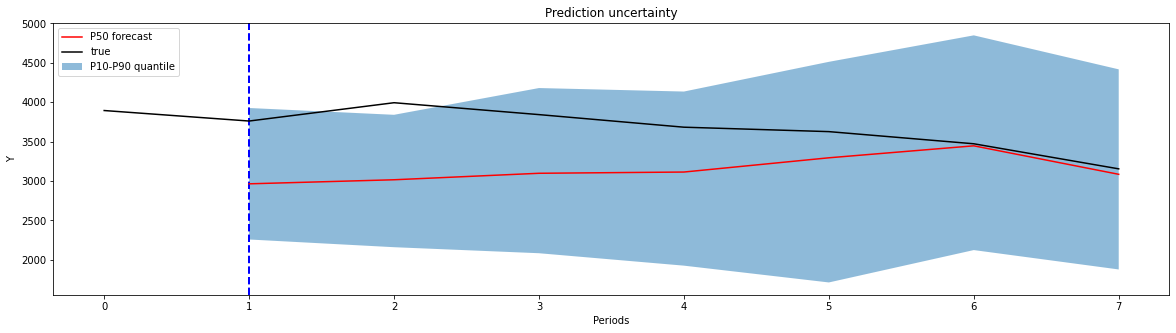

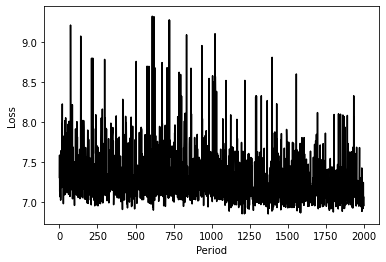

In [ ]:

if args.run_test:
    data_path = util.get_data_path()
    data = pd.read_csv(os.path.join(data_path, "LD_MT200_hour.csv"), parse_dates=["date"])
    data["year"] = data["date"].apply(lambda x: x.year)
    data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)
    data = data.loc[(data["date"] >= pd.Timestamp(2014, 1, 1)) & (data["date"] <= pd.Timestamp(2014, 3, 1))]

    features = ["hour", "day_of_week"]
    # hours = pd.get_dummies(data["hour"])
    # dows = pd.get_dummies(data["day_of_week"])
    hours = data["hour"]
    dows = data["day_of_week"]
    X = np.c_[np.asarray(hours), np.asarray(dows)]
    num_features = X.shape[1]
    num_periods = len(data)
    X = np.asarray(X).reshape((-1, num_periods, num_features))
    y = np.asarray(data["MT_200"]).reshape((-1, num_periods))
    # X = np.tile(X, (10, 1, 1))
    # y = np.tile(y, (10, 1))
    losses, mape_list = train(X, y, args)
    if args.show_plot:
        plt.plot(range(len(losses)), losses, "k-")
        plt.xlabel("Period")
        plt.ylabel("Loss")
        plt.show()


In [ ]:
data['date_full'] = data.date + pd.to_timedelta(data.hour, unit='h')
data.head(30)


,date,hour,MT_200,year,day_of_week,date_full
26304,2014-01-01,0,1367.841410,2014,2,2014-01-01 00:00:00
26305,2014-01-01,1,1365.638767,2014,2,2014-01-01 01:00:00
26306,2014-01-01,2,1324.889868,2014,2,2014-01-01 02:00:00
26307,2014-01-01,3,1261.013216,2014,2,2014-01-01 03:00:00
26308,2014-01-01,4,1243.392070,2014,2,2014-01-01 04:00:00
26309,2014-01-01,5,1204.845815,2014,2,2014-01-01 05:00:00
26310,2014-01-01,6,1324.889868,2014,2,2014-01-01 06:00:00
26311,2014-01-01,7,1388.766520,2014,2,2014-01-01 07:00:00
26312,2014-01-01,8,1419.603524,2014,2,2014-01-01 08:00:00
26313,2014-01-01,9,1544.052863,2014,2,2014-01-01 09:00:00


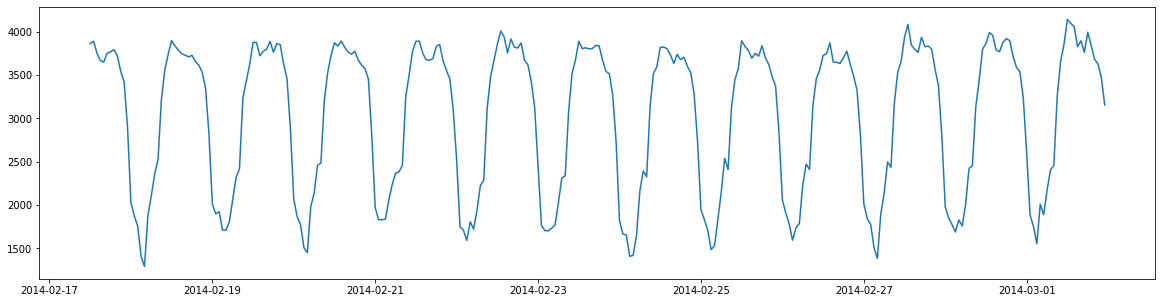

In [ ]:
plt.figure(1, figsize=(20, 5))

plt.plot(data.date_full[-300:], data.MT_200[-300:])